## Preparing the enviornment¶
There are some packages that need to be installed before running the codes. Which can be find in binder/requirements.txt file.

In [2]:
import os
import sys
import torch
import glob
import pandas as pd
import numpy as np
import nilearn.connectome
import pathlib
from nilearn.input_data import NiftiMasker
from nilearn import image

sys.path.append(os.path.join(".."))
sys.path.append('../src')
import gcn_windows_dataset
import graph_construction
import gcn_model
import visualization

import warnings
warnings.filterwarnings(action='once')

## Fetching Haxby dataset

In this notebook, all the models are trained on the *Haxby* dataset.

Dataset can be download using the following command:

__*haxby_ds = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir=data_dir)*__

Also, We could easily removed resting state tasks at the time of selecting data. That would give us higher accuracy results.

__*X = masker.fit_transform(func_file)[nonrest_task_mask]* \
*y = labels['labels'][nonrest_task_mask]*__

The event design labels in this dataset are visual stimulus including:
- *'face', 'chair', 'scissors', 'shoe', 'scrambledpix', 'house', 'cat', 'bottle' and 'rest'*


In [3]:
# We have already fetched the data for subject 4
data_dir = os.path.join('..', 'data')
raw_data_dir = os.path.join(data_dir, 'haxby2001','subj4')
func_file = os.path.join(raw_data_dir,'bold.nii.gz')
session_target = os.path.join(raw_data_dir,'labels.txt')

# Standardizing
mask_vt_file = os.path.join(raw_data_dir,'mask4_vt.nii.gz')
masker = NiftiMasker(mask_img=mask_vt_file, standardize=True)

labels = pd.read_csv(session_target, sep=" ")

# Selecting data
X = masker.fit_transform(func_file)
y = labels['labels']

## Checking the data
Here we see the shape and the labels of this data sample, which we need to check before start training model!

In [4]:
categories = y.unique()
print(categories)
print(y.shape)
print(X.shape)

['rest' 'face' 'chair' 'scissors' 'shoe' 'scrambledpix' 'house' 'cat'
 'bottle']
(1452,)
(1452, 675)


# Graph Convolutional Networks (GCN)

### Model pipeline:
- Takes a short series of fMRI volumes as input.
- Maps the fMRI signals onto a predefined brain graph.
- Propagates brain dynamics information on inter-connected brain regions & networks.
- Generates task-specific representations of recorded brain activities. 
- Predicts the corresponding task states.


- __6__ graph convolutional layers
- __32 graph filters__  at each layer
- followed by a __global average pooling__ layer
- __2 fully connected__ layers 

<img src="GCN_pipeline.png" width=850 height=420 />

## Data paths

In [5]:
proc_path = os.path.join(data_dir, 'haxby_proc/')
concat_path = os.path.join(data_dir, 'haxby_concat/')
conn_path = os.path.join(data_dir, 'haxby_connectomes/')
split_path = os.path.join(data_dir, 'haxby_split_win/')

## Generating connectomes

In [6]:
# Estimating connectomes
corr_measure = nilearn.connectome.ConnectivityMeasure(kind="correlation")
conn = corr_measure.fit_transform([X])[0]

# np.save(os.path.join(conn_path, 'conn_subj{}.npy'.format(sub_no)), conn)

conn_files = sorted(glob.glob(conn_path + '/*.npy'))

## Split dataset

Here we will split the processed data into three diferent sets for train, validation, and test.

In [7]:
random_seed = 0

train_dataset = gcn_windows_dataset.TimeWindowsDataset(
    data_dir=split_path
    , partition="train"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True,
    shuffle = True)

valid_dataset = gcn_windows_dataset.TimeWindowsDataset(
    data_dir=split_path
    , partition="valid"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True, 
    shuffle = True)

test_dataset = gcn_windows_dataset.TimeWindowsDataset(
    data_dir=split_path
    , partition="test"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True, 
    shuffle = True)

print("train dataset: {}".format(train_dataset))
print("valid dataset: {}".format(valid_dataset))
print("test dataset: {}".format(test_dataset))

train dataset: 1016*(torch.Size([675, 1]), ())
valid dataset: 290*(torch.Size([675, 1]), ())
test dataset: 146*(torch.Size([675, 1]), ())


In [8]:
torch.manual_seed(random_seed)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_generator = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)
train_features, train_labels = next(iter(train_generator))
print(f"Feature batch shape: {train_features.size()}; mean {torch.mean(train_features)}")
print(f"Labels batch shape: {train_labels.size()}; mean {torch.mean(torch.Tensor.float(train_labels))}")

Feature batch shape: torch.Size([16, 675, 1]); mean -6.18122220075179e-09
Labels batch shape: torch.Size([16]); mean 3.6875


## Getting connectomes
We will get the average connectome.

In [9]:
connectomes = []
for conn_file in conn_files:
      connectomes += [np.load(conn_file)]

## Building brain graphs

After loading brain connectome, we will build brain garph.
__k-Nearest Neighbours(KNN) graph__ for the group average connectome will be built based on the connectivity-matrix.

Each node is only connected to *k* other neighbours, which is __8 nodes__ with the strongest regions connectivity in this experiment.

For more details you please check out __*src/graph_construction.py*__ script.

In [10]:
graph = graph_construction.make_group_graph(connectomes, self_loops=False, 
                                            k=8, symmetric=True)

## Running model

__*Time windows*__

For the GCN model in order to run the model on different sizes of input, we will concatenate bold data of the same stimuli and save it in a single file.

It means that we need to extract the fmri time-series for each trial using the event design labels.

Different lengths for our input data can be selected. 
In this example we will continue with __*window_length = 1*__, which means each input file will have a length equal to just one Repetition Time (TR).

In [11]:
window_length = 1
gcn = gcn_model.GCN(graph.edge_index, graph.edge_attr, 
                           n_timepoints=window_length)
gcn

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


GCN(
  (conv1): ChebConv(1, 32, K=2, normalization=sym)
  (conv2): ChebConv(32, 32, K=2, normalization=sym)
  (conv3): ChebConv(32, 16, K=2, normalization=sym)
  (fc1): Linear(in_features=10800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=21, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Train and evaluating the model

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)    

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss, current = loss.item(), batch * dataloader.batch_size

        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= X.shape[0]
        print(f"#{batch:>5};\ttrain_loss: {loss:>0.3f};\ttrain_accuracy:{(100*correct):>5.1f}%\t\t[{current:>5d}/{size:>5d}]")

def valid_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model.forward(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= size
    correct /= size

    return loss, correct

## Start training
We will repeat the process for 15 epochs (times), and will evaluate the model based on the average accuracy and loss of these epochs.

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-4, weight_decay=5e-4)

epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loop(train_generator, gcn, loss_fn, optimizer)
    loss, correct = valid_test_loop(valid_generator, gcn, loss_fn)
    print(f"Valid metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")

Epoch 1/15
-------------------------------
#    0;	train_loss: 3.090;	train_accuracy:  0.0%		[    0/ 1016]
#    1;	train_loss: 3.029;	train_accuracy:  0.0%		[   16/ 1016]
#    2;	train_loss: 2.985;	train_accuracy: 37.5%		[   32/ 1016]
#    3;	train_loss: 2.912;	train_accuracy: 50.0%		[   48/ 1016]
#    4;	train_loss: 2.919;	train_accuracy: 31.2%		[   64/ 1016]
#    5;	train_loss: 2.737;	train_accuracy: 50.0%		[   80/ 1016]
#    6;	train_loss: 2.755;	train_accuracy: 43.8%		[   96/ 1016]
#    7;	train_loss: 2.802;	train_accuracy: 18.8%		[  112/ 1016]
#    8;	train_loss: 2.544;	train_accuracy: 50.0%		[  128/ 1016]
#    9;	train_loss: 2.313;	train_accuracy: 62.5%		[  144/ 1016]
#   10;	train_loss: 2.629;	train_accuracy: 31.2%		[  160/ 1016]
#   11;	train_loss: 2.588;	train_accuracy: 31.2%		[  176/ 1016]
#   12;	train_loss: 2.502;	train_accuracy: 31.2%		[  192/ 1016]
#   13;	train_loss: 2.106;	train_accuracy: 56.2%		[  208/ 1016]
#   14;	train_loss: 2.251;	train_accuracy: 37.5%		[  224/ 101

#   62;	train_loss: 1.933;	train_accuracy: 37.5%		[  992/ 1016]
#   63;	train_loss: 1.461;	train_accuracy: 50.0%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.115811;	 avg_accuracy: 45.2%
Epoch 3/15
-------------------------------
#    0;	train_loss: 1.494;	train_accuracy: 56.2%		[    0/ 1016]
#    1;	train_loss: 1.398;	train_accuracy: 56.2%		[   16/ 1016]
#    2;	train_loss: 1.070;	train_accuracy: 56.2%		[   32/ 1016]
#    3;	train_loss: 1.924;	train_accuracy: 31.2%		[   48/ 1016]
#    4;	train_loss: 1.703;	train_accuracy: 37.5%		[   64/ 1016]
#    5;	train_loss: 2.448;	train_accuracy: 12.5%		[   80/ 1016]
#    6;	train_loss: 2.035;	train_accuracy: 31.2%		[   96/ 1016]
#    7;	train_loss: 1.704;	train_accuracy: 37.5%		[  112/ 1016]
#    8;	train_loss: 1.639;	train_accuracy: 37.5%		[  128/ 1016]
#    9;	train_loss: 1.538;	train_accuracy: 62.5%		[  144/ 1016]
#   10;	train_loss: 1.442;	train_accuracy: 56.2%		[  160/ 1016]
#   11;	train_loss: 1.027;	train_accuracy: 81.2%		[  176/ 1016]
#  

#   59;	train_loss: 0.921;	train_accuracy: 75.0%		[  944/ 1016]
#   60;	train_loss: 1.231;	train_accuracy: 56.2%		[  960/ 1016]
#   61;	train_loss: 1.398;	train_accuracy: 50.0%		[  976/ 1016]
#   62;	train_loss: 1.435;	train_accuracy: 68.8%		[  992/ 1016]
#   63;	train_loss: 1.416;	train_accuracy: 62.5%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.082941;	 avg_accuracy: 55.5%
Epoch 5/15
-------------------------------
#    0;	train_loss: 1.055;	train_accuracy: 68.8%		[    0/ 1016]
#    1;	train_loss: 1.036;	train_accuracy: 68.8%		[   16/ 1016]
#    2;	train_loss: 1.552;	train_accuracy: 43.8%		[   32/ 1016]
#    3;	train_loss: 0.951;	train_accuracy: 62.5%		[   48/ 1016]
#    4;	train_loss: 1.395;	train_accuracy: 37.5%		[   64/ 1016]
#    5;	train_loss: 0.913;	train_accuracy: 62.5%		[   80/ 1016]
#    6;	train_loss: 1.483;	train_accuracy: 62.5%		[   96/ 1016]
#    7;	train_loss: 1.817;	train_accuracy: 37.5%		[  112/ 1016]
#    8;	train_loss: 1.313;	train_accuracy: 56.2%		[  128/ 1016]
#  

#   56;	train_loss: 0.628;	train_accuracy: 75.0%		[  896/ 1016]
#   57;	train_loss: 0.835;	train_accuracy: 81.2%		[  912/ 1016]
#   58;	train_loss: 0.981;	train_accuracy: 75.0%		[  928/ 1016]
#   59;	train_loss: 0.959;	train_accuracy: 68.8%		[  944/ 1016]
#   60;	train_loss: 0.768;	train_accuracy: 68.8%		[  960/ 1016]
#   61;	train_loss: 1.070;	train_accuracy: 56.2%		[  976/ 1016]
#   62;	train_loss: 1.048;	train_accuracy: 56.2%		[  992/ 1016]
#   63;	train_loss: 0.434;	train_accuracy: 87.5%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.067415;	 avg_accuracy: 62.4%
Epoch 7/15
-------------------------------
#    0;	train_loss: 0.599;	train_accuracy: 87.5%		[    0/ 1016]
#    1;	train_loss: 1.232;	train_accuracy: 50.0%		[   16/ 1016]
#    2;	train_loss: 0.989;	train_accuracy: 62.5%		[   32/ 1016]
#    3;	train_loss: 0.909;	train_accuracy: 68.8%		[   48/ 1016]
#    4;	train_loss: 1.029;	train_accuracy: 68.8%		[   64/ 1016]
#    5;	train_loss: 0.829;	train_accuracy: 68.8%		[   80/ 1016]
#  

#   53;	train_loss: 1.036;	train_accuracy: 56.2%		[  848/ 1016]
#   54;	train_loss: 1.092;	train_accuracy: 68.8%		[  864/ 1016]
#   55;	train_loss: 0.602;	train_accuracy: 81.2%		[  880/ 1016]
#   56;	train_loss: 0.883;	train_accuracy: 75.0%		[  896/ 1016]
#   57;	train_loss: 0.561;	train_accuracy: 87.5%		[  912/ 1016]
#   58;	train_loss: 0.526;	train_accuracy: 87.5%		[  928/ 1016]
#   59;	train_loss: 0.537;	train_accuracy: 93.8%		[  944/ 1016]
#   60;	train_loss: 0.490;	train_accuracy: 87.5%		[  960/ 1016]
#   61;	train_loss: 1.128;	train_accuracy: 62.5%		[  976/ 1016]
#   62;	train_loss: 0.440;	train_accuracy: 93.8%		[  992/ 1016]
#   63;	train_loss: 0.318;	train_accuracy: 87.5%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.058284;	 avg_accuracy: 72.8%
Epoch 9/15
-------------------------------
#    0;	train_loss: 0.367;	train_accuracy: 93.8%		[    0/ 1016]
#    1;	train_loss: 0.567;	train_accuracy: 81.2%		[   16/ 1016]
#    2;	train_loss: 0.434;	train_accuracy: 87.5%		[   32/ 1016]
#  

#   50;	train_loss: 0.444;	train_accuracy: 81.2%		[  800/ 1016]
#   51;	train_loss: 0.285;	train_accuracy: 93.8%		[  816/ 1016]
#   52;	train_loss: 0.427;	train_accuracy: 93.8%		[  832/ 1016]
#   53;	train_loss: 0.437;	train_accuracy: 93.8%		[  848/ 1016]
#   54;	train_loss: 0.225;	train_accuracy: 93.8%		[  864/ 1016]
#   55;	train_loss: 0.433;	train_accuracy: 87.5%		[  880/ 1016]
#   56;	train_loss: 0.608;	train_accuracy: 75.0%		[  896/ 1016]
#   57;	train_loss: 0.553;	train_accuracy: 87.5%		[  912/ 1016]
#   58;	train_loss: 0.505;	train_accuracy: 93.8%		[  928/ 1016]
#   59;	train_loss: 0.250;	train_accuracy: 93.8%		[  944/ 1016]
#   60;	train_loss: 0.360;	train_accuracy: 93.8%		[  960/ 1016]
#   61;	train_loss: 0.198;	train_accuracy: 93.8%		[  976/ 1016]
#   62;	train_loss: 0.239;	train_accuracy: 93.8%		[  992/ 1016]
#   63;	train_loss: 0.216;	train_accuracy:100.0%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.054693;	 avg_accuracy: 72.8%
Epoch 11/15
-------------------------------
# 

#   47;	train_loss: 0.195;	train_accuracy:100.0%		[  752/ 1016]
#   48;	train_loss: 0.166;	train_accuracy:100.0%		[  768/ 1016]
#   49;	train_loss: 0.223;	train_accuracy: 93.8%		[  784/ 1016]
#   50;	train_loss: 0.179;	train_accuracy:100.0%		[  800/ 1016]
#   51;	train_loss: 0.112;	train_accuracy:100.0%		[  816/ 1016]
#   52;	train_loss: 0.210;	train_accuracy: 93.8%		[  832/ 1016]
#   53;	train_loss: 0.106;	train_accuracy:100.0%		[  848/ 1016]
#   54;	train_loss: 0.205;	train_accuracy: 87.5%		[  864/ 1016]
#   55;	train_loss: 0.216;	train_accuracy: 93.8%		[  880/ 1016]
#   56;	train_loss: 0.261;	train_accuracy: 93.8%		[  896/ 1016]
#   57;	train_loss: 0.089;	train_accuracy:100.0%		[  912/ 1016]
#   58;	train_loss: 0.142;	train_accuracy:100.0%		[  928/ 1016]
#   59;	train_loss: 0.096;	train_accuracy:100.0%		[  944/ 1016]
#   60;	train_loss: 0.329;	train_accuracy: 93.8%		[  960/ 1016]
#   61;	train_loss: 0.463;	train_accuracy: 81.2%		[  976/ 1016]
#   62;	train_loss: 0.176;	train_accurac

#   44;	train_loss: 0.338;	train_accuracy: 87.5%		[  704/ 1016]
#   45;	train_loss: 0.156;	train_accuracy:100.0%		[  720/ 1016]
#   46;	train_loss: 0.096;	train_accuracy: 93.8%		[  736/ 1016]
#   47;	train_loss: 0.127;	train_accuracy:100.0%		[  752/ 1016]
#   48;	train_loss: 0.143;	train_accuracy:100.0%		[  768/ 1016]
#   49;	train_loss: 0.316;	train_accuracy: 93.8%		[  784/ 1016]
#   50;	train_loss: 0.126;	train_accuracy:100.0%		[  800/ 1016]
#   51;	train_loss: 0.197;	train_accuracy:100.0%		[  816/ 1016]
#   52;	train_loss: 0.039;	train_accuracy:100.0%		[  832/ 1016]
#   53;	train_loss: 0.149;	train_accuracy: 93.8%		[  848/ 1016]
#   54;	train_loss: 0.245;	train_accuracy: 93.8%		[  864/ 1016]
#   55;	train_loss: 0.148;	train_accuracy: 93.8%		[  880/ 1016]
#   56;	train_loss: 0.215;	train_accuracy: 93.8%		[  896/ 1016]
#   57;	train_loss: 0.109;	train_accuracy:100.0%		[  912/ 1016]
#   58;	train_loss: 0.025;	train_accuracy:100.0%		[  928/ 1016]
#   59;	train_loss: 0.149;	train_accurac

## Rasults

In [14]:
loss, correct = valid_test_loop(test_generator, gcn, loss_fn) 
print(f"Test metrics:\n\t avg_loss: {loss:>f};\t avg_accuracy: {(100*correct):>0.1f}%")

Test metrics:
	 avg_loss: 0.050327;	 avg_accuracy: 76.0%


# multilayer perceptron (MLP)

- with 2 dense layers
- 10 fold cross validation
- 20% test size

In [15]:
import keras
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from nilearn.plotting import plot_anat, show, plot_stat_map, plot_matrix

In [16]:
# Encoding the string to numerical values.
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

# reshapeing y
temp = np.reshape(y, (len(y),1))
y = temp

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# passing bridge-types-cat column (label encoded values of bridge_types)
y = pd.DataFrame(enc.fit_transform(y).toarray())
y

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1447,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1448,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1449,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1450,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Split dataset
We will shuffle and split the data into training and test sets.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = 0)

#standarize features caling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Initializing the model

In [18]:
# number of unique conditions that we have
mlp_classifier = Sequential()

# Adding the input layer and the first hidden layer
mlp_classifier.add(Dense(338 , input_dim = 675, kernel_initializer="uniform", activation = 'relu'))

# Adding the second hidden layer
mlp_classifier.add(Dense(169, kernel_initializer="uniform", activation = 'relu'))

# Using softmax at the end, lenght of categories shows the number of labels we have
mlp_classifier.add(Dense(len(categories), activation = 'softmax'))

In [19]:
mlp_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 338)               228488    
_________________________________________________________________
dense_1 (Dense)              (None, 169)               57291     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1530      
Total params: 287,309
Trainable params: 287,309
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Compiling the model
mlp_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [21]:
# Fitting the model on the Training set
history = mlp_classifier.fit(X_train, y_train, batch_size = 10,
                             epochs = 10, validation_split = 0.2)

Epoch 1/10
93/93 [==============================] - 1s 9ms/step - loss: 1.4508 - accuracy: 0.5162 - val_loss: 1.3387 - val_accuracy: 0.5451
Epoch 2/10
93/93 [==============================] - 1s 9ms/step - loss: 0.8958 - accuracy: 0.6961 - val_loss: 1.1616 - val_accuracy: 0.6137
Epoch 3/10
93/93 [==============================] - 1s 6ms/step - loss: 0.5498 - accuracy: 0.8168 - val_loss: 1.0519 - val_accuracy: 0.6481
Epoch 4/10
93/93 [==============================] - 1s 9ms/step - loss: 0.3595 - accuracy: 0.8966 - val_loss: 1.2021 - val_accuracy: 0.6567
Epoch 5/10
93/93 [==============================] - 1s 9ms/step - loss: 0.3025 - accuracy: 0.8987 - val_loss: 0.8810 - val_accuracy: 0.7296
Epoch 6/10
93/93 [==============================] - 1s 6ms/step - loss: 0.1692 - accuracy: 0.9494 - val_loss: 1.2050 - val_accuracy: 0.6953
Epoch 7/10
93/93 [==============================] - 1s 6ms/step - loss: 0.1047 - accuracy: 0.9634 - val_loss: 1.1252 - val_accuracy: 0.7210
Epoch 8/10
93/93 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


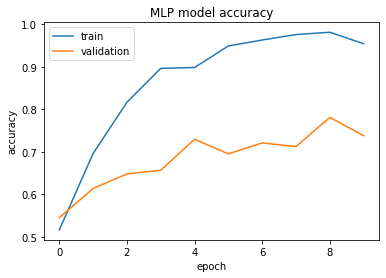

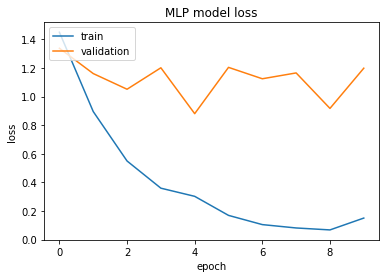

In [22]:
plot_history = visualization.classifier_history (history, 'MLP ')

mean accuracy score: 0.81


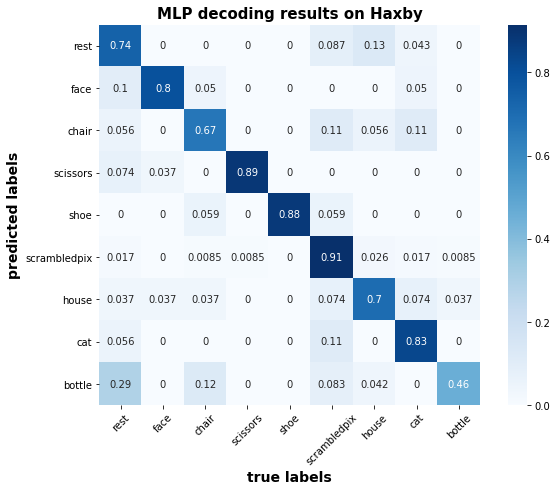

In [23]:
# Making the predictions and evaluating the model
y_pred = mlp_classifier.predict(X_test)
y_pred = (y_pred > 0.5)

print ('mean accuracy score:', np.round(accuracy_score(y_test.values.argmax(axis = 1), 
                                                       y_pred.argmax(axis=1), normalize = True, 
                                                       sample_weight=None),2))

# Confusion matrix
cm_mlp = confusion_matrix(y_test.values.argmax(axis = 1), y_pred.argmax(axis=1))
model_conf_matrix = cm_mlp.astype('float') / cm_mlp.sum(axis = 1)[:, np.newaxis]

visualization.conf_matrix(model_conf_matrix, 
                          categories, 
                          title='MLP decoding results on Haxby')

## An exercise
In the following cells, we will train __Support vector machines(SVM)__ classifier that besides being a simple and memory-efficient model is usually very successful in high dimensional spaces. But in some cases, it has a risk of overfitting.

We are aiming to run an SVM model with:
- 10 folds cross validation
- 20% test size

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

# Selecting data
X = masker.fit_transform(func_file)
y = labels['labels']

# Encoding the string to numerical values
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)   

# prepare the cross-validation procedure
cv = KFold(n_splits = 10, random_state = 0, shuffle = True)

# Initializing the SVM model
model_svm = SVC(decision_function_shape = 'ovo', random_state = 0, kernel='linear')
# model_svm.fit(X_train, y_train)

# evaluate model
scores = cross_val_score(model_svm, X_test, y_test, 
                         scoring = 'accuracy', cv = cv, n_jobs = -1)    
y_pred = cross_val_predict(model_svm, X_test, y_test, cv = cv)
report = classification_report(y_test, y_pred)

print(report)
print(scores)
print('mean accuracy:%.4f' % np.mean(scores))

              precision    recall  f1-score   support

           0       0.32      0.52      0.39        23
           1       0.47      0.40      0.43        20
           2       0.26      0.33      0.29        18
           3       0.84      0.78      0.81        27
           4       0.82      0.53      0.64        17
           5       0.88      0.88      0.88       117
           6       0.33      0.26      0.29        27
           7       0.69      0.61      0.65        18
           8       0.43      0.42      0.43        24

    accuracy                           0.64       291
   macro avg       0.56      0.53      0.53       291
weighted avg       0.66      0.64      0.65       291

[0.6        0.51724138 0.62068966 0.75862069 0.68965517 0.72413793
 0.68965517 0.5862069  0.62068966 0.62068966]
mean accuracy:0.6428


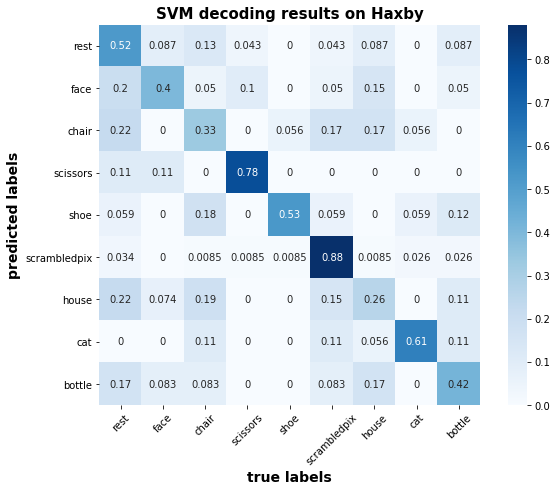

In [25]:
# confusion matrix
cm_svm = confusion_matrix(y_test, y_pred)
model_conf_matrix = cm_svm.astype('float') / cm_svm.sum(axis = 1)[:, np.newaxis]

visualization.conf_matrix(model_conf_matrix, 
                          categories, 
                          title='SVM decoding results on Haxby')